In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
class EmotionDataset(Dataset):
    def __init__(self, data_file, max_length=512):
        with open(data_file, 'r') as f:
            data = json.load(f)
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.max_length = max_length
        self.label_mapping = {
            'disgust': 0,
            'anger': 1,
            'sadness': 2,
            'surprise': 3,
            'neutral': 4,
            'joy': 5,
            'fear': 6,
            '<PAD>': 7
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        utterance = self.data[idx]['utterances']
        speaker = self.data[idx]['speakers']
        final_utterance = [u + ' ' + s for u, s in zip(utterance, speaker)]
        final_utterance = final_utterance + [self.tokenizer.pad_token] * (24 - len(final_utterance))

        final_emotions = self.data[idx]['emotions']
        final_emotions = final_emotions + [self.tokenizer.pad_token] * (24 - len(final_emotions))
        emotion_labels = []
        for emotion in final_emotions:
            if emotion in self.label_mapping:
                emotion_labels.append(self.label_mapping[emotion])
            else:
                emotion_labels.append(self.label_mapping['<PAD>'])  

        inputs = self.tokenizer(final_utterance, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='np')
        input_ids = torch.tensor(inputs['input_ids'], dtype=torch.float32)


        num_classes = len(self.label_mapping)
        emotion_labels_one_hot = F.one_hot(torch.tensor(emotion_labels), num_classes=num_classes).float()

        return input_ids, emotion_labels_one_hot

train_data_file = '/Data/train_file.json'
train_dataset = EmotionDataset(train_data_file)
val_data_file = '/Data/val_file.json'
val_dataset = EmotionDataset(val_data_file)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torch.nn as nn
from transformers import BertModel
from tqdm import tqdm
class BiLSTMWithEmotions(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=768, dropout=0.1):
        super(BiLSTMWithEmotions, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.fc3 = nn.Linear(768, 192)
        self.relu = nn.ReLU()
        model_name = 'bert-base-uncased'
        self.model = BertModel.from_pretrained(model_name)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, input_ids):
        lstm_output, _ = self.lstm(input_ids)
        lstm_output = self.dropout(lstm_output)
        pooled_output, _ = torch.max(lstm_output, dim=1)
        fc1_output = self.relu(self.fc1(pooled_output))
        output = self.fc3(self.fc2(fc1_output))
        output = self.softmax(output.view(output.size(0), 24, -1))
        return output



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model = BiLSTMWithEmotions(input_size=512).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

from sklearn.metrics import f1_score

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.argmax(outputs, 2)
        labels = torch.argmax(labels, 2)
        total += labels.size(0) * labels.size(1)
        correct += (predicted == labels).sum().item()
        
        y_true.extend(labels.view(-1).cpu().numpy())
        y_pred.extend(predicted.view(-1).cpu().numpy())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_f1 = f1_score(y_true, y_pred, average='macro')
    return train_loss, train_acc, train_f1


def val(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            predicted = torch.argmax(outputs, 2)
            labels = torch.argmax(labels, 2)
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.view(-1).cpu().numpy())
            y_pred.extend(predicted.view(-1).cpu().numpy())

            running_loss += loss.item()
    
        val_loss = running_loss / len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(y_true, y_pred, average='macro')
        return val_loss, val_acc, val_f1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = val(model, val_loader, criterion, device)
    

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
 
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, val Loss: {val_loss:.4f}, val Acc: {val_acc:.4f}, val F1: {val_f1:.4f}")


100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


Epoch 1/20, Train Loss: 9.5254, Train Acc: 0.2786, Train F1: 0.1276, val Loss: 9.5194, val Acc: 0.3617, val F1: 0.1445


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch 2/20, Train Loss: 9.5094, Train Acc: 0.4243, Train F1: 0.1746, val Loss: 9.5011, val Acc: 0.4760, val F1: 0.1821


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 3/20, Train Loss: 9.4814, Train Acc: 0.5253, Train F1: 0.1942, val Loss: 9.4647, val Acc: 0.5878, val F1: 0.1801


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 4/20, Train Loss: 9.4102, Train Acc: 0.6145, Train F1: 0.1816, val Loss: 9.3550, val Acc: 0.6393, val F1: 0.1690


100%|██████████| 27/27 [00:03<00:00,  8.04it/s]


Epoch 5/20, Train Loss: 9.2429, Train Acc: 0.6487, Train F1: 0.1746, val Loss: 9.1933, val Acc: 0.6504, val F1: 0.1674


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 6/20, Train Loss: 9.1412, Train Acc: 0.6768, Train F1: 0.1721, val Loss: 9.1433, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 7/20, Train Loss: 9.1160, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1296, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 8/20, Train Loss: 9.1098, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1252, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 9/20, Train Loss: 9.1068, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1220, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.00it/s]


Epoch 10/20, Train Loss: 9.1043, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1196, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch 11/20, Train Loss: 9.1028, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1185, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch 12/20, Train Loss: 9.1015, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1170, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


Epoch 13/20, Train Loss: 9.1007, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1163, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.95it/s]


Epoch 14/20, Train Loss: 9.0998, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1148, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.96it/s]


Epoch 15/20, Train Loss: 9.0989, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1136, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.97it/s]


Epoch 16/20, Train Loss: 9.0980, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1134, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch 17/20, Train Loss: 9.0970, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1118, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


Epoch 18/20, Train Loss: 9.0956, Train Acc: 0.6935, Train F1: 0.1710, val Loss: 9.1103, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.97it/s]


Epoch 19/20, Train Loss: 9.0943, Train Acc: 0.6934, Train F1: 0.1710, val Loss: 9.1085, val Acc: 0.6930, val F1: 0.1701


100%|██████████| 27/27 [00:03<00:00,  7.87it/s]


Epoch 20/20, Train Loss: 9.0926, Train Acc: 0.6935, Train F1: 0.1710, val Loss: 9.1068, val Acc: 0.6940, val F1: 0.1703


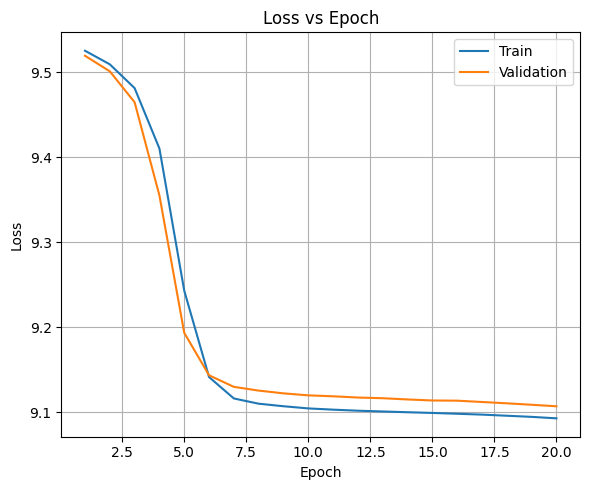

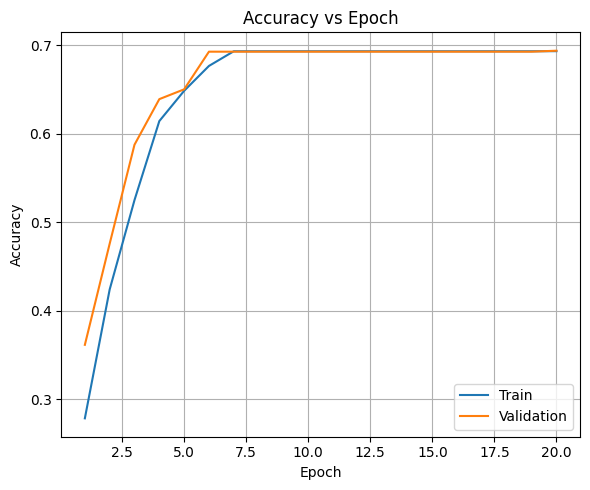

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.savefig('loss_plot1.png')
plt.show()  


plt.figure(figsize=(6, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.savefig('accuracy_plot1.png')
plt.show()  


In [5]:
torch.save(model.state_dict(), "/Model1.pkl")

In [11]:
from sklearn.metrics import classification_report


label_mapping = {
            'disgust': 0,
            'anger': 1,
            'sadness': 2,
            'surprise': 3,
            'neutral': 4,
            'joy': 5,
            'fear': 6,
            '<PAD>': 7
        }

y_true_val = []
y_pred_val = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        predicted = torch.argmax(outputs, 2)
        labels = torch.argmax(labels, 2)

        y_true_val.extend(labels.view(-1).cpu().numpy())
        y_pred_val.extend(predicted.view(-1).cpu().numpy())


y_true_val_decoded = [list(label_mapping.keys())[list(label_mapping.values()).index(label)] for label in y_true_val]
y_pred_val_decoded = [list(label_mapping.keys())[list(label_mapping.values()).index(label)] for label in y_pred_val]


print("Classification Report on Validation Data:")
print(classification_report(y_true_val_decoded, y_pred_val_decoded))


100%|██████████| 27/27 [00:03<00:00,  7.96it/s]
/home/seraj/miniconda3/envs/gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seraj/miniconda3/envs/gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report on Validation Data:
              precision    recall  f1-score   support

       <PAD>       0.86      0.90      0.88     12939
       anger       0.00      0.00      0.00       788
     disgust       0.00      0.00      0.00       215
        fear       0.00      0.00      0.00       265
         joy       0.00      0.00      0.00      1259
     neutral       0.36      0.75      0.48      3200
     sadness       0.00      0.00      0.00       558
    surprise       0.00      0.00      0.00      1008

    accuracy                           0.69     20232
   macro avg       0.15      0.21      0.17     20232
weighted avg       0.61      0.69      0.64     20232



/home/seraj/miniconda3/envs/gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
